**Quora Question Pairs**

**1. Business Problem**

**1.1 Description**

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


> Credits: Kaggle

**__ Problem Statement __**
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

 **1.2 Sources/Useful Links**

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

**1.3 Real world/Business Objectives and Constraints**

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

**2.0 Data Information**

**2.1  Data Overview**

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

**2.2  Example Data point**

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

**3.0 Mapping the real world problem to an ML problem**

**3.1 Type of Machine Leaning Problem**

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

**3.2 Performance Metric**

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

**3.3 Train and Test Construction**

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

**4.0 Exploratory Data Analysis**

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [17]:
!pip install fuzzywuzzy

**4.1  Reading data and basic stats**

In [0]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**We are given a minimal number of data fields here, consisting of:**

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

**4.2.1 Distribution of data points among output classes**
- Number of duplicate(smilar) and non-duplicate(non similar) questions

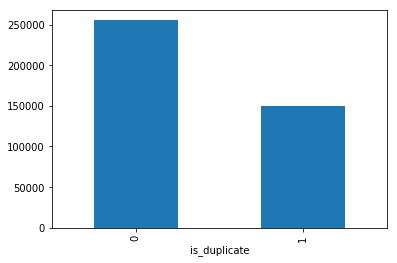

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('\n~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   404290

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


**4.2.2 Number of unique questions**

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist()) # Adding in one column
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



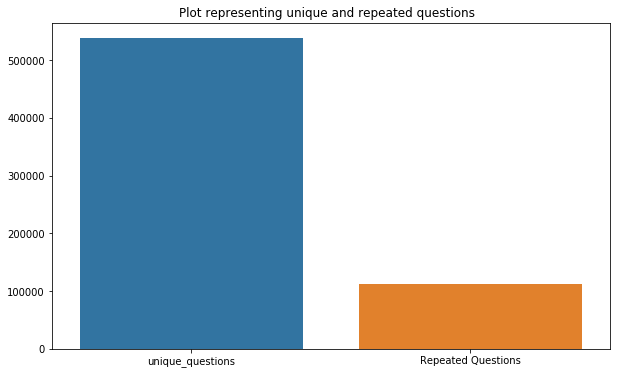

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

**4.2.3  Checking for Duplicates**

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


**4.2.4 Number of occurrences of each question**

Maximum number of times a single question is repeated: 157



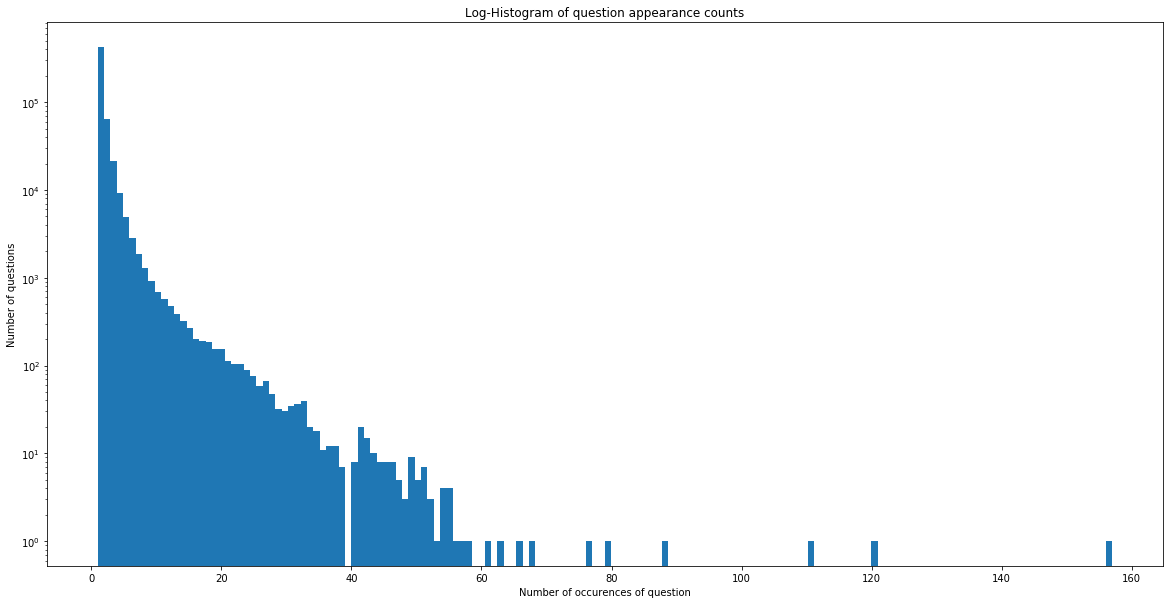

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

**4.2.5 Checking for NULL values**

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


There are two rows with null values in question2

In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**4.3 Basic Feature Extraction (before cleaning)**

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [0]:
if os.path.isfile("/content/drive/My Drive/ML_Assignment/df_fe_without_preprocessing_train.csv"):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
      
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

   
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
      
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("/content/drive/My Drive/ML_Assignment/df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


**4.3.1 Analysis of some of the extracted features**

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


**4.3.2 Feature: word_share**

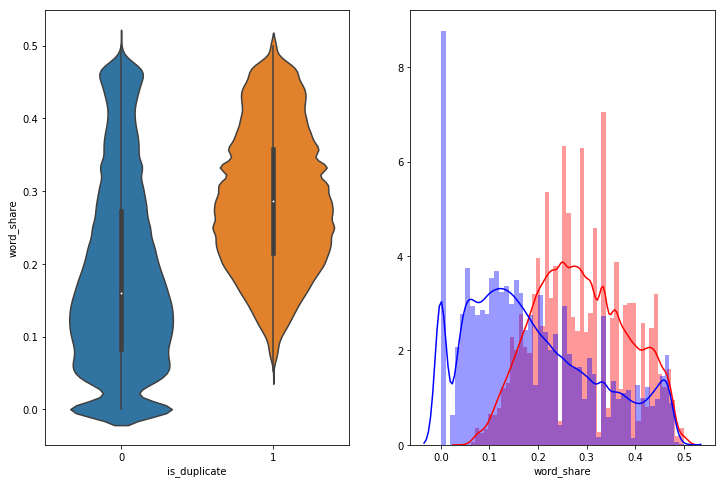

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity

The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**4.3.3  Feature: word_Common**

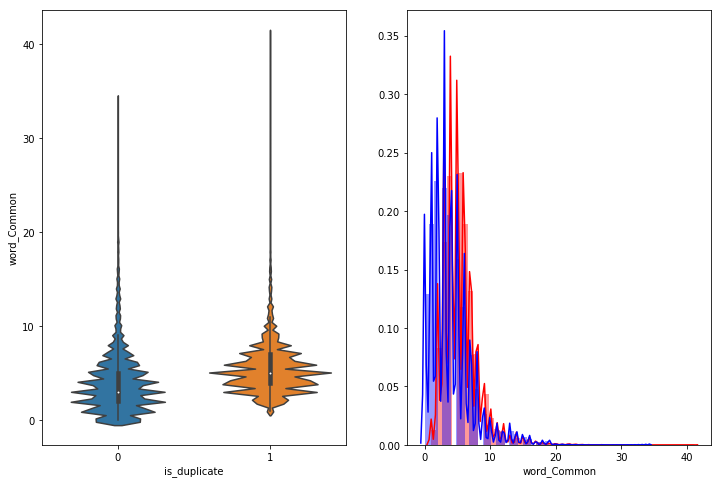

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

**5.0 EDA: Advanced Feature Extraction**

**5.1 Preprocessing of Text**

Preprocessing:

        Removing html tags

        Removing Punctuations

        Performing stemming

        Removing Stopwords

       Expanding contractions etc.

In [0]:
# To get the results in 4 decemal points

import nltk
nltk.download('stopwords')

SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Function to Compute and get the features : With 2 parameters of Question 1 and Question 2


In [0]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

**5.2 Advanced Feature Extraction (NLP and Fuzzy Features)**

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
!pip install Distance

     |████████████████████████████████| 184kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built Distance


In [0]:
import distance

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


In [0]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [0]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
if os.path.isfile('/content/drive/My Drive/ML_Assignment/nlp_features_train.csv'):
    df = pd.read_csv("/content/drive/My Drive/ML_Assignment/nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/My Drive/Quora/train.csv")
    df = extract_features(df)
    df.to_csv("/content/drive/My Drive/ML_Assignment/nlp_features_train.csv", index=False)

Extracting features for train:
token features...
fuzzy features..


**6.0 Analysis of extracted features**

**6.1 Plotting Word clouds**

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('/content/drive/My Drive/ML_Assignment/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('/content/drive/My Drive/ML_Assignment/train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, '/content/drive/My Drive/ML_Assignment/train_p.txt')).read()
textn_w = open(path.join(d, '/content/drive/My Drive/ML_Assignment/train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


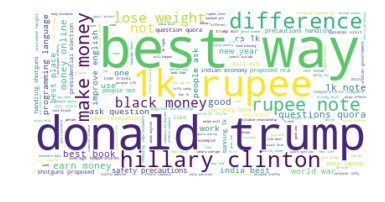

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


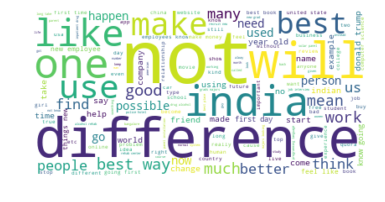

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**6.2  Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']**

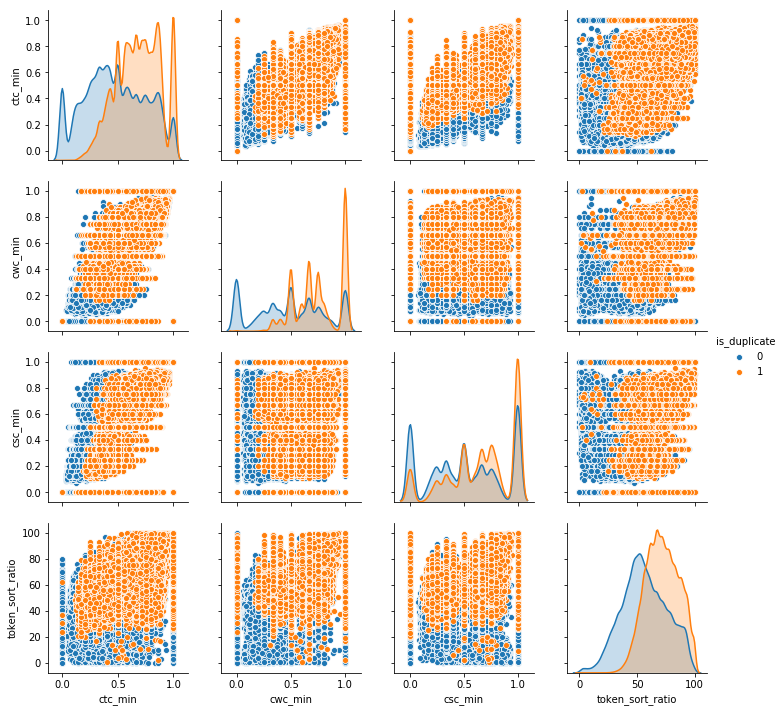

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

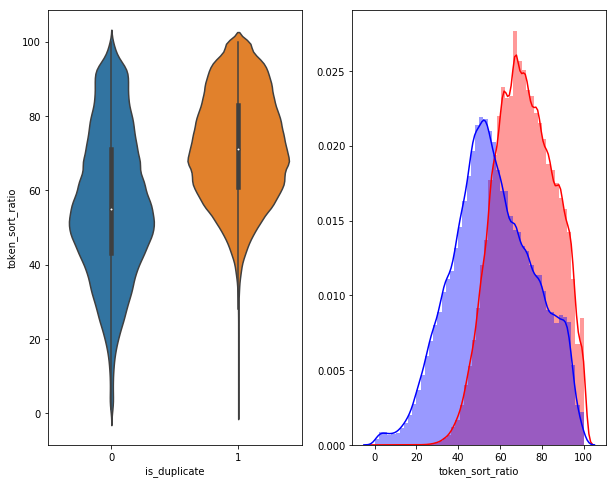

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

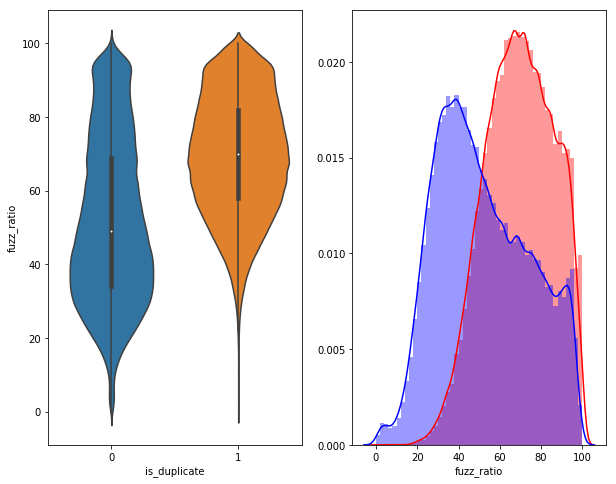

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

**6.3 Visualization**

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.303s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 2.987s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 2.054s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 1.935s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 2.015s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



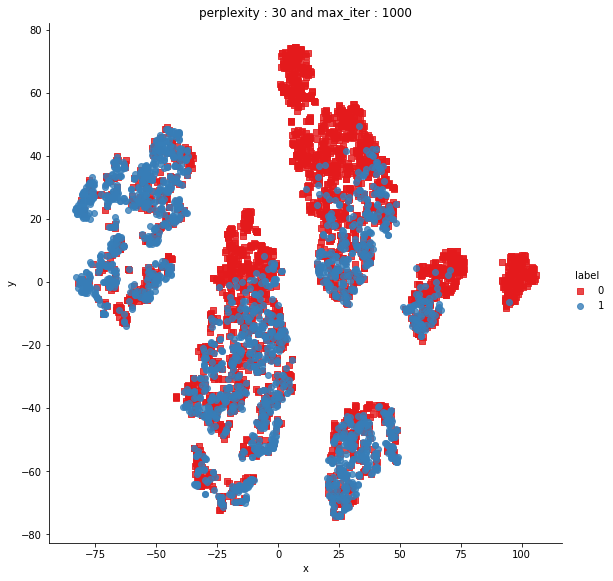

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

**7. Machine Learning Models**

In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('/content/drive/My Drive/ML_Assignment/nlp_features_train.csv'):
    dfnlp = pd.read_csv("/content/drive/My Drive/ML_Assignment/nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('/content/drive/My Drive/ML_Assignment/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("/content/drive/My Drive/ML_Assignment/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [0]:
df1.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [0]:
df2.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [0]:
df3.columns

Index(['id', 'question1', 'question2'], dtype='object')

In [0]:
df3 = df3.fillna(' ')
df4 = pd.DataFrame()
df4['Text'] = df3.question1 + ' ' + df3.question2
df4['id'] = df3.id

In [0]:
df2['id']=df1['id']
df4['id']=df1['id']
df5  = df1.merge(df2, on='id',how='left')
final  = df5.merge(df4, on='id',how='left')

In [0]:
final.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'Text'],
      dtype='object')

In [0]:
final = final.drop('id',axis=1)

**7.1 Random train test split( 70:30)**

In [0]:
from sklearn.model_selection import train_test_split
X_train_tf,X_test_tf, y_train_tf, y_test_tf = train_test_split(final,duplicate, test_size=0.3,random_state=13)

In [0]:
print("Number of data points in train data :",X_train_tf.shape)
print("Number of data points in test data :",X_test_tf.shape)

Number of data points in train data : (283003, 27)
Number of data points in test data : (121287, 27)


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,3),max_features=200000,min_df=0.000032)
train_tfidf = tfidf_vect.fit_transform(X_train_tf.Text)
test_tfidf = tfidf_vect.transform(X_test_tf.Text)
print('No of Tfidf features',len(tfidf_vect.get_feature_names()))

No of Tfidf features 122820


In [0]:
X_train_tf = X_train_tf.drop('Text',axis=1)
X_test_tf = X_test_tf.drop('Text',axis=1)

In [0]:
from scipy.sparse import hstack
X_train1 = hstack((X_train_tf.values,train_tfidf))
X_test1 = hstack((X_test_tf.values,test_tfidf))

In [0]:
X_train1

<283003x122846 sparse matrix of type '<class 'numpy.float64'>'
	with 16061987 stored elements in COOrdinate format>

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],-
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

**7.2 Logistic Regression with hyperparameter tuning**

**7.2.1 Hyper-Parameter Tuning**

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train1, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train_tf)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  1e-05 The log loss is: 0.38623914881517596


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.0001 The log loss is: 0.4111481284848784


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.001 The log loss is: 0.42689999873675494


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.01 The log loss is: 0.44990204615421514


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.1 The log loss is: 0.4646282585440264


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  1 The log loss is: 0.49319818487236194


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  10 The log loss is: 0.5438487664049481


**7.2.2 Plot**

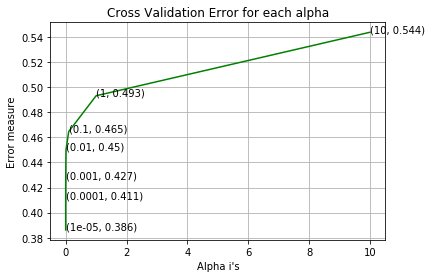

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

**7.2.3 Training the model**

In [0]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train1, y_train_tf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train_tf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                           

In [0]:
predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  1e-05 The train log loss is: 0.3818035869208524
For values of best alpha =  1e-05 The test log loss is: 0.38623914881517596
Total number of data points : 121287


**7.2.4 Confusion Matrix**

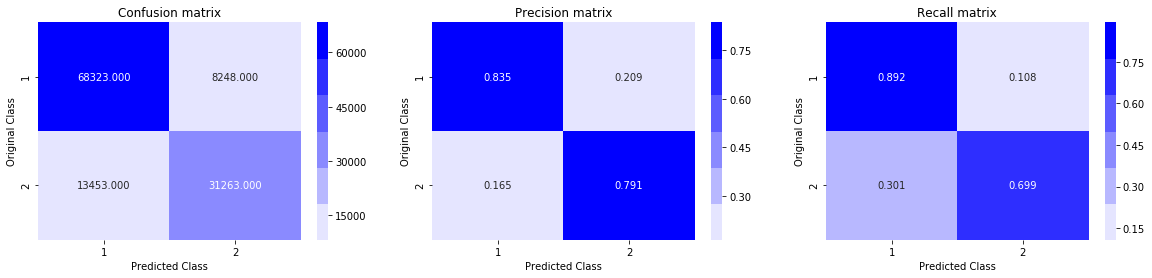

In [0]:
plot_confusion_matrix(y_test_tf, predicted_y)

**7.3 Linear SVM with hyperparameter tuning**

**7.3.1 Hyper-Parameter Tuning**

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train1, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train_tf)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  1e-05 The log loss is: 0.42124503639436617


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.0001 The log loss is: 0.43304992470768194


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.001 The log loss is: 0.4673372051580693


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



For values of alpha =  0.01 The log loss is: 0.48645355970672305


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  0.1 The log loss is: 0.48645809998786416


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  1 The log loss is: 0.5794309516525658


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



For values of alpha =  10 The log loss is: 0.5888447150012679


**7.3.2 Plot**

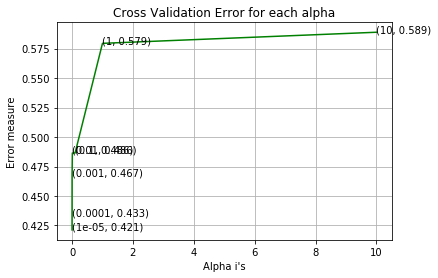

In [31]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

**7.3.3 Training the model**

In [32]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train1, y_train_tf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train_tf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:453: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/sklearn/calibration.py:455: RuntimeWarning:

invalid value encountered in multiply



CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                         

In [33]:
predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  1e-05 The train log loss is: 0.41970659828576473
For values of best alpha =  1e-05 The test log loss is: 0.42124503639436617
Total number of data points : 121287


**7.3.4 Confusion Matrix**

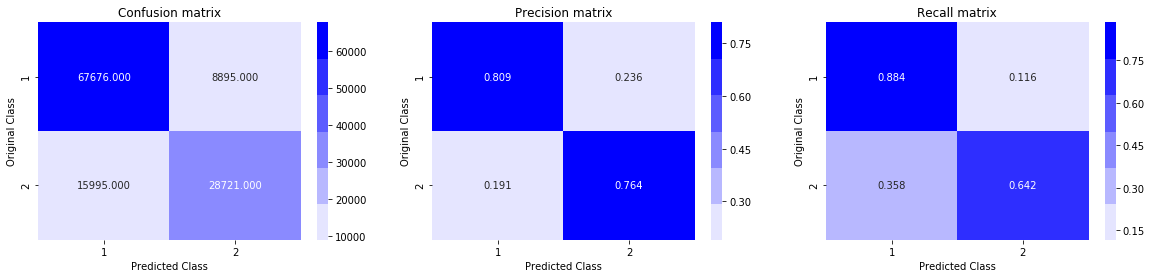

In [34]:
plot_confusion_matrix(y_test_tf, predicted_y)

**7.4 XGBoost**

In [0]:
XGBData = final.head(20000)
XGB_Y=duplicate.head(20000)

In [36]:
XGBData.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,Text
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...


In [0]:
from sklearn.model_selection import train_test_split
X_train_tf,X_test_tf, y_train_tf, y_test_tf = train_test_split(XGBData,XGB_Y,test_size=0.3,random_state=13)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,3),max_features=500,min_df=0.000032)
train_tfidf = tfidf_vect.fit_transform(X_train_tf.Text)
test_tfidf = tfidf_vect.transform(X_test_tf.Text)
print('No of Tfidf features',len(tfidf_vect.get_feature_names()))

No of Tfidf features 500


In [0]:
X_train_tf = X_train_tf.drop('Text',axis=1)
X_test_tf = X_test_tf.drop('Text',axis=1)

In [0]:
from scipy.sparse import hstack
X_train1 = hstack((X_train_tf.values,train_tfidf))
X_test1 = hstack((X_test_tf.values,test_tfidf))

In [41]:
from scipy.stats import randint as sp_randint
import xgboost as xgb
from numpy.random import uniform
from sklearn.model_selection import RandomizedSearchCV


param_dist = {"max_depth": sp_randint(2,5),
              "n_estimators":sp_randint(300,600)
             }

model_rs_xgb1 = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_dist,
                                   n_iter=30,scoring='neg_log_loss',cv=5,n_jobs=-1)
model_rs_xgb1.fit(X_train1,y_train_tf)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=25, reg_alpha...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=30, n_jobs=-1,
                   param_distrib

In [0]:
best=model_rs_xgb1.best_params_ 

In [43]:
model= xgb.XGBClassifier(n_estimators=best['n_estimators'],max_depth=best['max_depth'])
model.fit(X_train1,y_train_tf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=419, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [51]:
from sklearn.metrics import log_loss
predict_y = model.predict_proba(X_train1)
print('For best value of n_estimators and max_depth respectively = ', best['n_estimators'],' , ',best['max_depth'], "The train log loss is:",log_loss(y_train_tf, predict_y, labels=model.classes_, eps=1e-15))

predict_y = model.predict_proba(X_test1)
print('\nFor best value of n_estimators and max_depth respectively =  ', best['n_estimators'],' , ',best['max_depth'], "The test log loss is:",log_loss(y_test_tf, predict_y, labels=model.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("\nTotal number of data points :", len(predicted_y))

For best value of n_estimators and max_depth respectively =  419  ,  4 The train log loss is: 0.2505693500059259

For best value of n_estimators and max_depth respectively =   419  ,  4 The test log loss is: 0.3543509956041001

Total number of data points : 6000


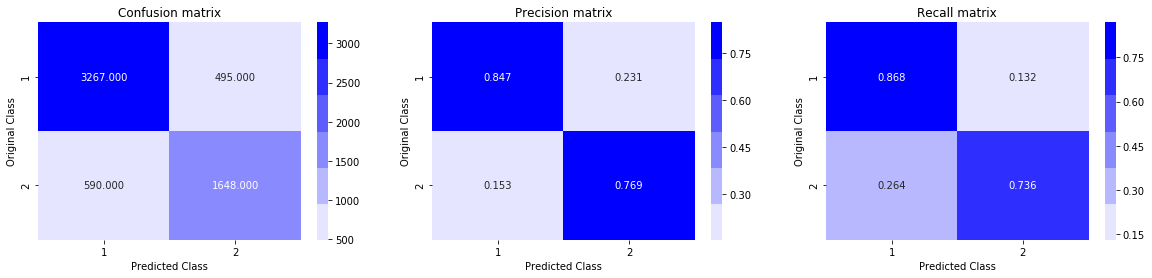

In [50]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test_tf, predicted_y)

### 8.0 Conclusion

1.0 Report Of Different Model

In [4]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names =['Machine Learning Algorithm' , 'Train Log-Loss','Test Log-Loss']
x.add_row(['Logistic Regression',0.38,0.38])
x.add_row(['Linear Support Vector Machine',0.41,0.42])
x.add_row(['XGBoost',0.25,0.34])

print(x)

+-------------------------------+----------------+---------------+
|   Machine Learning Algorithm  | Train Log-Loss | Test Log-Loss |
+-------------------------------+----------------+---------------+
|      Logistic Regression      |      0.38      |      0.38     |
| Linear Support Vector Machine |      0.41      |      0.42     |
|            XGBoost            |      0.25      |      0.34     |
+-------------------------------+----------------+---------------+


2. 404K data points have been used in case of Logistic Regression and Linear SVM.

3. Model is Underfit in case of XGBoost.